## 온라인 거래 데이터를 활용한 이상거래 탐지

> 비지도학습- 랜덤포레스트와 DNN을 통해 이상거래 탐지 모형 구축

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### 데이터의 경우  identity와 transaction인 두 파일로 나눠짐
    모든 거래 데이터가 해당 ID를 가지고 있는 것은 아님=>TransactionID로 join
    
> train_transaction, train_identity, test_transaction, test_identity

* Transaction의 변수 
    * ProductCD
    * emaildomain
    * card1-card6
    * addr1, addr2
    * P_emaildomain
    * M1 - M9


* Identity의 변수
    * DeviceType
    * Deviceinfo
    * id_12 - id_38

* 각 변수들은 범주형

* 두 파일을 합쳐 train, test 데이터로 사용하고자 함

In [5]:
os.chdir('C:\\Users\\Woodayoung\\Desktop\\Datastudy\\asiae\\data1')
train_transaction = pd.read_csv('train_transaction.csv', 
                                  index_col = 'TransactionID' )
train_identity = pd.read_csv('train_identity.csv', index_col = 'TransactionID')

test_transaction = pd.read_csv('test_transaction.csv', index_col = "TransactionID")
test_identity = pd.read_csv('test_identity.csv', index_col = "TransactionID")

In [6]:
# left join
train = train_transaction.merge(train_identity, how = 'left', left_index =True,
                                    right_index = True)
test = test_transaction.merge(test_identity, how = 'left', left_index =True,
                                 right_index=True)

In [7]:
print(train.shape)
print(test.shape)

(590540, 433)
(506691, 432)


### 데이터 탐색

In [8]:
train.head(3)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train.isnull().sum(axis=0)

isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
                   ...  
id_11             449562
id_12             446307
id_13             463220
id_14             510496
id_15             449555
id_16             461200
id_17             451171
id_18             545427
id_19             451222


#### ◎ 결측치 변수 제거

* NaN값이 많은 열들이 존재, 결측치가 97%를 초과할 경우 제거하기로 함

In [13]:
na_columns = [x for x in train.columns 
                if (train[x].isnull().sum(axis=0) / train.shape[0]) > 0.97 ]
na_columns_test = [x for x in test.columns 
                  if (test[x].isnull().sum(axis=0) / test.shape[0]) > 0.07 ]
# NaN 비율이 97% 이상인 열이면 제거 (임의의 비율)

In [14]:
columns_drop = list(set(na_columns + na_columns_test))
len(columns_drop) # 255개의 열을 제거

255

In [15]:
y_train = train['isFraud']
X_train = train.drop(columns=['isFraud'])
X_test = test.copy()

In [18]:
X_train = X_train.drop(columns_drop, axis = 1)
X_test = X_test.drop(columns_drop, axis = 1)

In [16]:
#del train_transaction, train_identity, test_transaction, test_identity
# 한번만 run

### 데이터 시각화

* 사기/비사기 데이터에 대한 시각화를 통해 의미있는 변수를 찾고자 함


    * 어떤 변수가 유의미한 패턴을 보이는지 확인 후, 유의하지 않은 변수는 제거
    * 사기/비사기를 나눠 확률분포를 본 후 차이가 있는지 확인
    * 비슷한 변수들의 경우 변수들 간 높은 상관성이 있는지 확인 후 feature로 사용

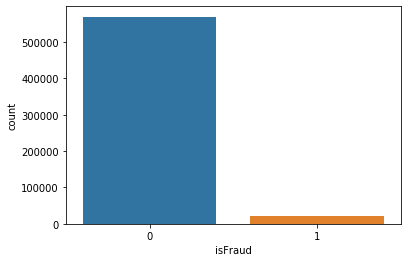

In [27]:
# 사기/ 비사기 도수 분포표
sns.countplot('isFraud', data = train)
plt.show()

In [28]:
y_train.value_counts(normalize=True) # evnet rate : about 3.5%

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

In [ ]:
## 시각화 하는 코드를 추가하고 결과 보여주면 좋을듯 - train데이터 이용하면 될듯

In [ ]:
## 통계 검정도 하면 더 좋긴함 - y 범주형, X 범주형 변수면 Chisqure 검정
## y 범주 , X 수치형이면 t-test검정 : 강사님의 titanic_02 통계검정부분 참고
## 유의수준 0.05 혹은 0.01로 두고 p-value가 그 값보다 작게나오면 유의한 변수

In [19]:
v_drop = [x for x in X_train.columns if x[0] == "V"]
c_drop = ['C1', 'C2','C5','C6','C9','C11', 'C14']

drop_cols = list(set(v_drop + c_drop))

X_train = X_train.drop(drop_cols, axis = 1)
X_test = X_test.drop(drop_cols, axis = 1)

* TransactionDT 변수는 주어진 참조 날짜 시간이며, 실제 time-stamp가 아님
    따라서 위의 변수를 제거하고자 함

In [22]:
X_train = X_train.drop('TransactionDT', axis=1)
X_test = X_test.drop('TransactionDT', axis=1)

In [23]:
print(X_train.shape)
print(X_test.shape)

(590540, 18)
(506691, 18)


#### 인코딩 : Label Encoding

In [25]:
# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values)) 
        
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

#### ◎ 로그변환 및 정규화

In [26]:
X_train.describe() #TransactionAmt, card1, card2 - log변환

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C3,C4,C7,C8,C10,C12,C13,D1,D10,D15
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,135.027176,3.220757,9898.734658,341.959466,150.141474,3.266305,190.636858,1.753033,0.005644,4.092185,2.848478,5.144574,5.240343,4.076227,32.539918,91.998095,-20.582750,-11.714590
std,239.162522,1.423926,4901.170153,228.343048,60.307775,1.035866,109.406317,0.449543,0.150536,68.848459,61.727304,95.378574,95.581443,86.666218,129.364844,165.428711,412.916821,456.207102
min,0.251000,0.000000,1000.000000,-999.000000,-999.000000,0.000000,-999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,-999.000000,-999.000000
25%,43.321000,3.000000,6019.000000,204.000000,150.000000,2.000000,166.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,68.769000,4.000000,9678.000000,360.000000,150.000000,4.000000,226.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,13.000000
75%,125.000000,4.000000,14184.000000,512.000000,150.000000,4.000000,226.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,121.000000,150.000000,251.000000
max,31937.391000,4.000000,18396.000000,600.000000,231.000000,4.000000,237.000000,4.000000,26.000000,2253.000000,2255.000000,3331.000000,3257.000000,3188.000000,2918.000000,640.000000,876.000000,879.000000


In [29]:
X_train['TransactionAmt'] = np.log(X_train['TransactionAmt'])
X_test['TransactionAmt'] = np.log(X_test['TransactionAmt'])

In [79]:
X_train = X_traina

In [80]:
X_test = X_testa

In [47]:
for c in ['card1', 'card2'] :

    X_train[c] = np.log(X_train[c]) 
    X_test[c] = np.log(X_test[c])

# card2의 경우 log(-999)값이 nan 처리됨
i=X_train.card2.isnull()
X_train.card2[i] = X_train.card2.mean()  #nan값을 평균값으로 대체

j=X_test.card2.isnull()
X_test.card2[j] = X_test.card2.mean()


c:\users\woodayoung\anaconda3\envs\study\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\woodayoung\anaconda3\envs\study\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
c:\users\woodayoung\anaconda3\envs\study\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\woodayoung\anaconda3\envs\study\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is 

In [48]:
X_train.isnull().sum(axis=0)

TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
C3                0
C4                0
C7                0
C8                0
C10               0
C12               0
C13               0
D1                0
D10               0
D15               0
dtype: int64

In [49]:
X_test.isnull().sum(axis=0)

TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
C3                0
C4                0
C7                0
C8                0
C10               0
C12               0
C13               0
D1                0
D10               0
D15               0
dtype: int64

* card3, card5, C4, C7, C8, C10, C12, C13, D1, D10, D15 변수 정규화

In [52]:
from sklearn.preprocessing import MinMaxScaler

In [85]:
colname = list(X_train.columns)
a= [0, 0, 0, 0, 1, 2, 2]

for i in a :
    colname.pop(i)

In [87]:
MMscaler = MinMaxScaler()

for c in colname :
    X_train[c] = MMscaler.fit_transform(X_train[[c]])
    X_test[c] = MMscaler.fit_transform(X_test[[c]])

X_test.head(3)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C3,C4,C7,C8,C10,C12,C13,D1,D10,D15
TransactionID,,,,,,,,,,,,,,,,,,
3663549,3.464172,4,9.250426,4.709530,0.933387,4,0.9911,2,0.0,0.384231,0.381298,0.498503,0.531383,0.309310,0.434986,0.864634,0.677990,0.673684
3663550,3.891820,4,8.359837,4.709530,0.933387,4,0.9911,2,0.0,0.384231,0.381298,0.498503,0.531383,0.309310,0.394768,0.700000,0.588517,0.781340
3663551,5.141664,4,8.406485,6.352629,0.933387,4,0.9911,2,0.0,0.384231,0.381298,0.498503,0.531383,0.309001,0.398672,0.692683,0.543062,0.524402


#### 데이터 불러오기 시간을 줄이기 위해 메모리 줄인 데이터 저장
* 다음 부터는 이 데이터를 불러와서 실행

In [88]:
X_test.to_csv("X_test1.csv", header = True, index = True)
X_train.to_csv("X_train1.csv", header = True, index = True)
#y_train.to_csv("y_train.csv", header = True, index = True)

## 학습

In [2]:
os.chdir(r"C:\Users\Woodayoung\Desktop\Datastudy\asiae\data1")

In [3]:
X_train = pd.read_csv('X_train1.csv', index_col = 'TransactionID')
X_test = pd.read_csv('X_test1.csv', index_col = 'TransactionID')
y_train = pd.read_csv('y_train.csv', index_col = 'TransactionID')

### 랜덤포레스트

In [4]:
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [90]:
X_train1, X_val, Y_train, Y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.15, 
                                                    random_state=42)

In [92]:
print(X_train1.shape)
print(Y_train.shape)

(501959, 18)
(501959,)


In [93]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train1, Y_train)
y_pred = rf.predict(X_val)
acc = np.mean(Y_val == y_pred )
print("SKLEARN Random Forest Accuracy = {:3.3f}".format(acc))

SKLEARN Random Forest Accuracy = 0.981


#### test 데이터로 예측한 값 저장하기

In [94]:
sub = pd.read_csv('sample_submission.csv', index_col = 'TransactionID' )

In [96]:
sub['isFraud_pred'] = rf.predict(X_test)
sub.to_csv("randomforest.csv", header = True, index = True)

In [97]:
sub.isFraud_pred.value_counts()

0    502098
1      4593
Name: isFraud_pred, dtype: int64

### 딥러닝

In [127]:
tf.reset_default_graph() # 그래프 초기화 - 노드들이 지워짐
tf.get_default_graph().get_operations() # 초기그래프의 노드들 확인

[]

In [128]:
X= np.array(X_train)
y = np.array(y_train)
headerX = X_train.columns

In [129]:
print(X.shape)
print(y.shape)

(590540, 18)
(590540, 1)


In [130]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y, test_size=0.3, random_state=123)
n_train_size = y_train2.shape[0]

#### 모델 구성 및 학습

In [131]:
model = tf.keras.Sequential() #layer를 차례로 쌓는 모델구조

In [132]:
m, n = X_train2.shape

In [133]:
#n_input = m*n # 입력층 개수
n_hidden1 = 300 # hidden layer 개수
n_hidden2 = 100 # hidden layer2 개수
n_outputs = 1 # 출력층 개수s

In [134]:
## layer 구성 
layer0 = tf.keras.layers.Flatten()
layer1 = tf.keras.layers.Dense(n_hidden1,
                               activation=tf.keras.activations.relu)
layer2 = tf.keras.layers.Dense(n_hidden2,
                               activation=tf.keras.activations.relu)
#activation function으로 relu사용

layer3 = tf.keras.layers.Dense(n_outputs,
                               activation=tf.keras.activations.sigmoid)


In [135]:
# 모델에 하나씩 쌓는다 . - 쌓으면 자동 연결됨(high level)
model.add(layer0)
model.add(layer1)
model.add(layer2)
model.add(layer3)

In [136]:
# 모델 자체에 들어가야하는 함수, 평가 척도등을 입력 - 학습할 준비
model.compile(optimizer=tf.train.AdamOptimizer(), #'SGD'
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [137]:
#학습을 시작 - weight를 업데이트
model.fit(X_train2, y_train2, epochs=50, batch_size=503)

Epoch 1/50
413378/413378 [==============================] - 3s 8us/sample - loss: 0.1402 - acc: 0.9651
Epoch 2/50
413378/413378 [==============================] - 3s 8us/sample - loss: 0.1366 - acc: 0.9651
Epoch 3/50
413378/413378 [==============================] - 3s 8us/sample - loss: 0.1352 - acc: 0.9651
Epoch 4/50
413378/413378 [==============================] - 3s 8us/sample - loss: 0.1333 - acc: 0.9654
Epoch 5/50
413378/413378 [==============================] - 3s 8us/sample - loss: 0.1320 - acc: 0.9659
Epoch 6/50
413378/413378 [==============================] - 4s 9us/sample - loss: 0.1305 - acc: 0.9662
Epoch 7/50
413378/413378 [==============================] - 4s 9us/sample - loss: 0.1296 - acc: 0.9663
Epoch 8/50
413378/413378 [==============================] - 4s 9us/sample - loss: 0.1293 - acc: 0.9665
Epoch 9/50
413378/413378 [==============================] - 4s 11us/sample - loss: 0.1280 - acc: 0.9667
Epoch 10/50
413378/413378 [==============================] - 4s 9us/samp

#### 테스트

In [138]:
# 평가하기 - 학습한 X에 대해 y정답률!(얼마나 정확도가 높은지)
test_loss, test_acc = model.evaluate(X_val2, y_val2)
test_loss, test_acc

177162/177162 [==============================] - 4s 21us/sample - loss: 0.1262 - acc: 0.9678


(0.12619655082217332, 0.9677809)

#### 예측

In [139]:
sub2 = pd.read_csv('sample_submission.csv', index_col = 'TransactionID' )

In [141]:
sub2['isFraud'] = model.predict(X_test)
sub2.to_csv("DNN1.csv", header = True, index = True)

In [142]:
sub2 = pd.read_csv('DNN1.csv', index_col = 'TransactionID' )

In [143]:
sub2['isFraud_pred'].value_counts()

0    432809
1     73882
Name: isFraud_pred, dtype: int64